In [3]:
import glob
import mne
import pandas as pd
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt

In [4]:
files_eeg_b= glob.glob(r"C:\Users\yehuda\pain_of_payment\Data_PoP\mindMonitor_*_b_*.csv", recursive= False)
files_eeg_q = glob.glob(r"C:\Users\yehuda\pain_of_payment\Data_PoP\mindMonitor_*_q_*.csv", recursive= False)

In [16]:
'''
test to check with one file
no need to run it - just for debbugging
'''
id_num = 1

ch_names = ['RAW_AF7', 'RAW_AF8']
ch_types = ['eeg', 'eeg']
sfreq = 256
info = mne.create_info(ch_names = ch_names, ch_types=ch_types, sfreq = sfreq)

# read the relevant data from Muse results 
df_data_total_10, df_data_before_5, df_data_after_5 = read_data(files_eeg_b[id_num-1])

# calculate Power Spectral Density (for only df_data_total_10, you can change to other time frame)
df_data = df_data_total_10.transpose()
raw = mne.io.RawArray(df_data, info)
raw.filter(l_freq = 1, h_freq = 100, picks = 'eeg') #to check if needed- method = 'iir'
#raw.notch_filter(freqs=50, picks = 'eeg') - to check if needed
psd = raw.compute_psd(method = 'welch', picks = ['RAW_AF7', 'RAW_AF8'])
#psd.plot()
psd_df = psd.to_data_frame()

#filter to frequancies between 1-100Hz
psd_df = psd_df[(psd_df["freq"]<=100) & (psd_df["freq"]>=1)]
#optional - to save to csv
#psd_df.to_csv("psd_df.csv")

# calculate frequancies bands
freq_bands = dict(delta=(0.1,4), theta=(4,7), alpha=(8,15), beta=(16,31), gamma=(32,100))
columns = [('RAW_AF7', 'delta'), ('RAW_AF7', 'theta'), ('RAW_AF7', 'alpha'), ('RAW_AF7', 'beta'), ('RAW_AF7', 'gamma'), \
          ('RAW_AF8', 'delta'), ('RAW_AF8', 'theta'), ('RAW_AF8', 'alpha'), ('RAW_AF8', 'beta'), ('RAW_AF8', 'gamma')]


subject_data={}
i=0
for wave, tuple_range in freq_bands.items():
    wave_band_RAW_AF7 = (psd_df[(psd_df['freq'] >= tuple_range[0]) & (psd_df['freq'] <= tuple_range[1])]['RAW_AF7']).mean()
    subject_data[columns[i]] = [wave_band_RAW_AF7]
    i += 1
for wave, tuple_range in freq_bands.items():
    wave_band_RAW_AF8 = (psd_df[(psd_df['freq'] >= tuple_range[0]) & (psd_df['freq'] <= tuple_range[1])]['RAW_AF8']).mean()
    subject_data[columns[i]] = [wave_band_RAW_AF8]
    i += 1
df_subject_data = pd.DataFrame(subject_data)
df_subject_data.columns = pd.MultiIndex.from_tuples(df_subject_data.columns, names=['channel','wave'])
df_subject_data['subject'] = id_num
#optional - to save to csv
#df_subject_data.to_csv("df_subject_data.csv")

# add subject payment method:
questionarie = pd.read_excel(r"C:\Users\yehuda\pain_of_payment\Pain of Payment Questionnaire.xlsx",\
                             usecols = ['Payment_method'], sheet_name='Sheet0')
questionarie.drop(0, inplace=True)

df_subject_data['Payment_method'] = questionarie['Payment_method'].loc[id_num]

Creating RawArray with float64 data, n_channels=2, n_times=2832
    Range : 0 ... 2831 =      0.000 ...    11.059 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


In [41]:
'''
reading EEG measurements from time of buy +- 5 seconds 
using only the data from RAW_AF7 and RAW_AF8 electtrodes
'''
def read_data(file):
    
    # read data drom file
    df_data = pd.read_csv(file, low_memory=False, usecols = ['TimeStamp','RAW_AF7','RAW_AF8','ToB'])
    
    # adjust the time frame to be +- 5 seconds from time of buy
    ToB = pd.to_timedelta(df_data["ToB"].loc[0])
    before_5Sec = ToB - pd.to_timedelta("0:0:05")
    after_5Sec = ToB + pd.to_timedelta("0:0:05")
    df_data["TimeStamp"] = pd.to_timedelta(df_data["TimeStamp"])
    df_data_total_10 = df_data[(df_data["TimeStamp"] <= after_5Sec) & (df_data["TimeStamp"] >= before_5Sec)].copy()
    df_data_before_5 = df_data[(df_data["TimeStamp"] <= ToB) & (df_data["TimeStamp"] >= before_5Sec)].copy()
    df_data_after_5 = df_data[(df_data["TimeStamp"] <= after_5Sec) & (df_data["TimeStamp"] >= ToB)].copy()
    
    
    # use only the channels series (RAW_AF7,RAW_AF8) and only valid ones (not Nan)
    df_data_total_10.drop(["ToB", "TimeStamp"], inplace = True, axis=1)
    df_data_total_10.dropna(inplace=True)
    df_data_before_5.drop(["ToB", "TimeStamp"], inplace = True, axis=1)
    df_data_before_5.dropna(inplace=True)
    df_data_after_5.drop(["ToB", "TimeStamp"], inplace = True, axis=1)
    df_data_after_5.dropna(inplace=True)
    
    #optional - to save to csv
    #df_data_total_10.to_csv("df_data_total_10.csv",index=False)
    #df_data_before_5.to_csv("df_data_before_5.csv",index=False)
    #df_data_after_5.to_csv("df_data_after_5.csv",index=False)
    
    return df_data_total_10, df_data_before_5, df_data_after_5

In [42]:
'''
Analyzing the EEG data:
calculate Power Spectral Density
'''
def PSD(df_data, info, time_frame_str):
    df_data = df_data.transpose()
    raw = mne.io.RawArray(df_data, info)
    raw.filter(l_freq = 1, h_freq = 100, picks = 'eeg')  #to check if needed- method = 'iir'
     #raw.notch_filter(freqs=50, picks = 'eeg') - to check if needed
    
    # calculate Power Spectral Density 
    psd = raw.compute_psd(method = 'welch', picks = ['RAW_AF7', 'RAW_AF8'])
   
    
    # optional - to plot
    #psd.plot()
    
    psd_df = psd.to_data_frame()
    
    #filter to frequancies between 1-100Hz
    psd_df = psd_df[(psd_df["freq"]<=100) & (psd_df["freq"]>=1)]
    
    #optional - to save to csv
    #file_name = "psd_df" +  time_frame_str + ".csv"
    #psd_df.to_csv(file_name)
    
    return psd_df

In [46]:
'''
calculate the mean of each wave band: delta, theta, alpha,beta, gama 
'''
def wave_bands(psd_df, bands, num_subject, time_frame_str):
    
    columns = [('RAW_AF7', 'delta'), ('RAW_AF7', 'theta'), ('RAW_AF7', 'alpha'), ('RAW_AF7', 'beta'), ('RAW_AF7', 'gamma'), \
          ('RAW_AF8', 'delta'), ('RAW_AF8', 'theta'), ('RAW_AF8', 'alpha'), ('RAW_AF8', 'beta'), ('RAW_AF8', 'gamma')]
    subject_data={}
    i=0
    
    for wave, wave_range in bands.items():
        wave_band_RAW_AF7 = (psd_df[(psd_df['freq'] >= wave_range[0]) & (psd_df['freq'] <= wave_range[1])]['RAW_AF7']).mean()
        subject_data[columns[i]] = [wave_band_RAW_AF7]
        i += 1
    for wave, wave_range in freq_bands.items():
        wave_band_RAW_AF8 = (psd_df[(psd_df['freq'] >= wave_range[0]) & (psd_df['freq'] <= wave_range[1])]['RAW_AF8']).mean()
        subject_data[columns[i]] = [wave_band_RAW_AF8]
        i += 1
        
    df_subject_data = pd.DataFrame(subject_data)
    
#     # rearnge the DataFrame so that each channel (RAW_AF7, RAW_AF8) has its own seperation to waves
#     df_subject_data.columns = pd.MultiIndex.from_tuples(df_subject_data.columns, names=['channel','wave'])
    
    df_subject_data['subject'] = num_subject
    
    #optional - to save to csv
    #file_name = "psd_df" +  time_frame_str + ".csv"
    #df_subject_data.to_csv("df_subject_data.csv")
    
    return df_subject_data

In [47]:
'''
main function
proccessing to each subject its EEG data from the ToB:
1. the mean of each band wave
2. the payment method (takes the answer from the questionarie)
'''
# initilaize variables
num_subject = 1
df_all_subjects_data_total_10 = pd.DataFrame()
df_all_subjects_data_before_5 = pd.DataFrame()
df_all_subjects_data_after_5 = pd.DataFrame()

freq_bands = dict(delta=(0.1,4), theta=(4,7), alpha=(8,15), beta=(16,31), gamma=(32,100))

# read the questionarie payment information
questionarie = pd.read_excel(r"C:\Users\yehuda\pain_of_payment\Pain of Payment Questionnaire.xlsx",\
                             usecols = ['Payment_method'], sheet_name='Sheet0')
questionarie.drop(0, inplace=True)

# create info about the EEG expieremrnt
ch_names = ['RAW_AF7', 'RAW_AF8']
ch_types = ['eeg', 'eeg']
sfreq = 256
info = mne.create_info(ch_names = ch_names, ch_types=ch_types, sfreq = sfreq)

for file in files_eeg_b:
        
    # read the relevant data from Muse results 
    df_data_total_10, df_data_before_5, df_data_after_5 = read_data(file)
    
    # calculate Power Spectral Density, for each time frame
    df_PSD_total_10 = PSD(df_data_total_10, info, "_total_10")
    df_PSD_before_5 = PSD(df_data_before_5, info, "_before_5")
    df_PSD_after_5 = PSD(df_data_after_5, info, "_after_5")
    
    # seperate to frequacies bands (waves) and calculate the mean for each wave, for each time frame
    df_subject_data_total_10 = wave_bands(df_PSD_total_10, freq_bands, num_subject, "_total_10")
    df_subject_data_before_5 = wave_bands(df_PSD_before_5, freq_bands, num_subject, "_before_5")
    df_subject_data_after_5 = wave_bands(df_PSD_after_5, freq_bands, num_subject, "_after_5")
    
    #add the payment method of the subject, for each time frame
    df_subject_data_total_10['Payment_method'] = questionarie['Payment_method'].loc[num_subject]
    df_subject_data_before_5['Payment_method'] = questionarie['Payment_method'].loc[num_subject]
    df_subject_data_after_5['Payment_method'] = questionarie['Payment_method'].loc[num_subject]
    
    # add current subject data to all the data that was collected so far, for each time frame
    df_all_subjects_data_total_10 = pd.concat([df_all_subjects_data_total_10, df_subject_data_total_10])
    df_all_subjects_data_before_5 = pd.concat([df_all_subjects_data_before_5, df_subject_data_before_5])
    df_all_subjects_data_after_5 = pd.concat([df_all_subjects_data_after_5, df_subject_data_after_5])
    
    num_subject += 1

# optional - to save to csv
df_all_subjects_data_total_10.to_csv("df_all_subjects_data_total_10.csv", encoding = 'utf-8-sig')
df_all_subjects_data_before_5.to_csv("df_all_subjects_data_before_5.csv", encoding = 'utf-8-sig')
df_all_subjects_data_after_5.to_csv("df_all_subjects_data_after_5.csv", encoding = 'utf-8-sig')

Creating RawArray with float64 data, n_channels=2, n_times=2832
    Range : 0 ... 2831 =      0.000 ...    11.059 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=2, n_times=1560
    Range : 0 ... 1559 =      0.000 ...     6.090 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concur

Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=2, n_times=2820
    Range : 0 ... 2819 =      0.000 ...    11.012 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=2, n_times=1536
    Range : 0 ... 1535 =      0.000 ...     5.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concur

Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=2, n_times=1536
    Range : 0 ... 1535 =      0.000 ...     5.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuati

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=2, n_times=1536
    Range : 0 ... 1535 =      0.000 ...     5.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=2, n_times=1536
    Range : 0 ... 1535 =      0.000 ...     5.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=2, n_times=2820
    Range : 0 ... 2819 =      0.000 ...    11.012 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=2, n_times=1548
    Range : 0 ... 1547 =      0.000 ...     6.043 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=2, n_times=2808
    Range : 0 ... 2807 =      0.000 ...    10.965 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=2, n_times=1536
    Range : 0 ... 1535 =      0.000 ...     5.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concur

- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=2, n_times=1524
    Range : 0 ... 1523 =      0.000 ...     5.949 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


    Range : 0 ... 1535 =      0.000 ...     5.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=2, n_times=1524
    Range : 0 ... 1523 =      0.000 ...     5.949 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed tim

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concur

Creating RawArray with float64 data, n_channels=2, n_times=2820
    Range : 0 ... 2819 =      0.000 ...    11.012 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=2, n_times=1536
    Range : 0 ... 1535 =      0.000 ...     5.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=2, n_times=2820
    Range : 0 ... 2819 =      0.000 ...    11.012 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=2, n_times=1536
    Range : 0 ... 1535 =      0.000 ...     5.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=2, n_times=1536
    Range : 0 ... 1535 =      0.000 ...     5.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 p

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


    Range : 0 ... 2823 =      0.000 ...    11.027 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=2, n_times=1540
    Range : 0 ... 1539 =      0.000 ...     6.012 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed tim

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=2, n_times=2772
    Range : 0 ... 2771 =      0.000 ...    10.824 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=2, n_times=1548
    Range : 0 ... 1547 =      0.000 ...     6.043 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concur

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=2, n_times=1560
    Range : 0 ... 1559 =      0.000 ...     6.090 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=2, n_times=2829
    Range : 0 ... 2828 =      0.000 ...    11.047 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=2, n_times=1534
    Range : 0 ... 1533 =      0.000 ...     5.988 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=2, n_times=2845
    Range : 0 ... 2844 =      0.000 ...    11.109 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=2, n_times=1548
    Range : 0 ... 1547 =      0.000 ...     6.043 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=2, n_times=2844
    Range : 0 ... 2843 =      0.000 ...    11.105 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=2, n_times=1572
    Range : 0 ... 1571 =      0.000 ...     6.137 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=2, n_times=2820
    Range : 0 ... 2819 =      0.000 ...    11.012 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=2, n_times=1536
    Range : 0 ... 1535 =      0.000 ...     5.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=2, n_times=2816
    Range : 0 ... 2815 =      0.000 ...    10.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=2, n_times=1508
    Range : 0 ... 1507 =      0.000 ...     5.887 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=2, n_times=2818
    Range : 0 ... 2817 =      0.000 ...    11.004 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=2, n_times=1532
    Range : 0 ... 1531 =      0.000 ...     5.980 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=2, n_times=2820
    Range : 0 ... 2819 =      0.000 ...    11.012 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=2, n_times=1536
    Range : 0 ... 1535 =      0.000 ...     5.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concur

Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=2, n_times=1536
    Range : 0 ... 1535 =      0.000 ...     5.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=2, n_times=2808
    Range : 0 ... 2807 =      0.000 ...    10.965 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=2, n_times=1536
    Range : 0 ... 1535 =      0.000 ...     5.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=2, n_times=2820
    Range : 0 ... 2819 =      0.000 ...    11.012 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=2, n_times=1560
    Range : 0 ... 1559 =      0.000 ...     6.090 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=2, n_times=2820
    Range : 0 ... 2819 =      0.000 ...    11.012 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=2, n_times=1542
    Range : 0 ... 1541 =      0.000 ...     6.020 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=2, n_times=2818
    Range : 0 ... 2817 =      0.000 ...    11.004 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=2, n_times=1539
    Range : 0 ... 1538 =      0.000 ...     6.008 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=2, n_times=2808
    Range : 0 ... 2807 =      0.000 ...    10.965 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=2, n_times=1536
    Range : 0 ... 1535 =      0.000 ...     5.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=2, n_times=2803
    Range : 0 ... 2802 =      0.000 ...    10.945 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=2, n_times=1516
    Range : 0 ... 1515 =      0.000 ...     5.918 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=2, n_times=2841
    Range : 0 ... 2840 =      0.000 ...    11.094 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=2, n_times=1569
    Range : 0 ... 1568 =      0.000 ...     6.125 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=2, n_times=2808
    Range : 0 ... 2807 =      0.000 ...    10.965 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=2, n_times=1524
    Range : 0 ... 1523 =      0.000 ...     5.949 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=2, n_times=2813
    Range : 0 ... 2812 =      0.000 ...    10.984 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=2, n_times=1541
    Range : 0 ... 1540 =      0.000 ...     6.016 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=2, n_times=2834
    Range : 0 ... 2833 =      0.000 ...    11.066 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=2, n_times=1550
    Range : 0 ... 1549 =      0.000 ...     6.051 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=2, n_times=2814
    Range : 0 ... 2813 =      0.000 ...    10.988 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=2, n_times=1530
    Range : 0 ... 1529 =      0.000 ...     5.973 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


    Range : 0 ... 2829 =      0.000 ...    11.051 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=2, n_times=1556
    Range : 0 ... 1555 =      0.000 ...     6.074 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed tim

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=2, n_times=2832
    Range : 0 ... 2831 =      0.000 ...    11.059 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=2, n_times=1536
    Range : 0 ... 1535 =      0.000 ...     5.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=2, n_times=2820
    Range : 0 ... 2819 =      0.000 ...    11.012 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=2, n_times=1548
    Range : 0 ... 1547 =      0.000 ...     6.043 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=2, n_times=2821
    Range : 0 ... 2820 =      0.000 ...    11.016 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=2, n_times=1536
    Range : 0 ... 1535 =      0.000 ...     5.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=2, n_times=2808
    Range : 0 ... 2807 =      0.000 ...    10.965 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=2, n_times=1524
    Range : 0 ... 1523 =      0.000 ...     5.949 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=2, n_times=2752
    Range : 0 ... 2751 =      0.000 ...    10.746 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=2, n_times=1496
    Range : 0 ... 1495 =      0.000 ...     5.840 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=2, n_times=2811
    Range : 0 ... 2810 =      0.000 ...    10.977 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=2, n_times=1539
    Range : 0 ... 1538 =      0.000 ...     6.008 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=2, n_times=2796
    Range : 0 ... 2795 =      0.000 ...    10.918 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=2, n_times=1538
    Range : 0 ... 1537 =      0.000 ...     6.004 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=2, n_times=2827
    Range : 0 ... 2826 =      0.000 ...    11.039 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=2, n_times=1519
    Range : 0 ... 1518 =      0.000 ...     5.930 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=2, n_times=2808
    Range : 0 ... 2807 =      0.000 ...    10.965 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=2, n_times=1524
    Range : 0 ... 1523 =      0.000 ...     5.949 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=2, n_times=2808
    Range : 0 ... 2807 =      0.000 ...    10.965 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=2, n_times=1546
    Range : 0 ... 1545 =      0.000 ...     6.035 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=2, n_times=2832
    Range : 0 ... 2831 =      0.000 ...    11.059 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=2, n_times=1548
    Range : 0 ... 1547 =      0.000 ...     6.043 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=2, n_times=2827
    Range : 0 ... 2826 =      0.000 ...    11.039 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=2, n_times=1555
    Range : 0 ... 1554 =      0.000 ...     6.070 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=2, n_times=2830
    Range : 0 ... 2829 =      0.000 ...    11.051 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=2, n_times=1526
    Range : 0 ... 1525 =      0.000 ...     5.957 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=2, n_times=2814
    Range : 0 ... 2813 =      0.000 ...    10.988 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=2, n_times=1530
    Range : 0 ... 1529 =      0.000 ...     5.973 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=2, n_times=2813
    Range : 0 ... 2812 =      0.000 ...    10.984 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=2, n_times=1524
    Range : 0 ... 1523 =      0.000 ...     5.949 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=2, n_times=2808
    Range : 0 ... 2807 =      0.000 ...    10.965 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=2, n_times=1512
    Range : 0 ... 1511 =      0.000 ...     5.902 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=2, n_times=2820
    Range : 0 ... 2819 =      0.000 ...    11.012 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=2, n_times=1548
    Range : 0 ... 1547 =      0.000 ...     6.043 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=2, n_times=2832
    Range : 0 ... 2831 =      0.000 ...    11.059 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=2, n_times=1572
    Range : 0 ... 1571 =      0.000 ...     6.137 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


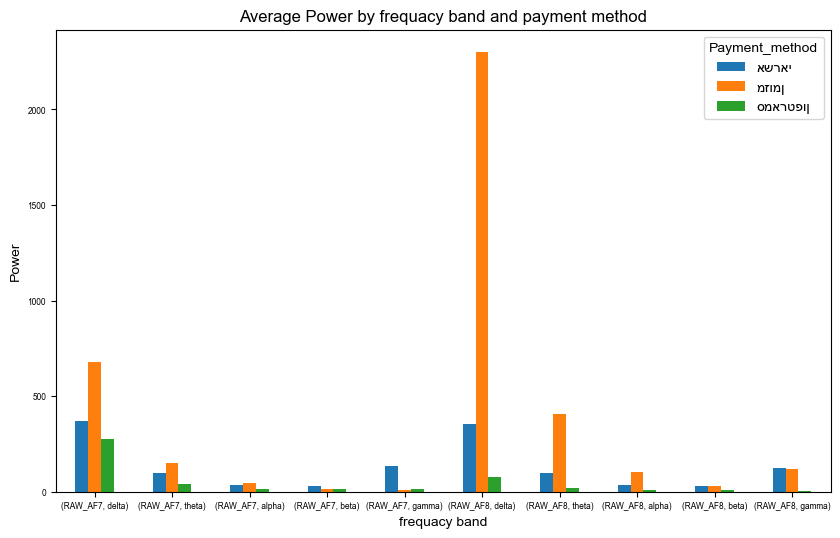

In [67]:
'''
calculate the mean power of each wave-band as a function of payment method
and display the results
for each time frame
'''

df_PSD_based_payment_total_10 = df_all_subjects_data_total_10.groupby('Payment_method').mean().drop(labels='subject', level=0, axis=1)
df_PSD_based_payment_before_5 = df_all_subjects_data_before_5.groupby('Payment_method').mean().drop(labels='subject', level=0, axis=1)
df_PSD_based_payment_after_5 = df_all_subjects_data_after_5.groupby('Payment_method').mean().drop(labels='subject', level=0, axis=1)

df_PSD_based_payment_total_10
df_PSD_based_payment_before_5
df_PSD_based_payment_after_5


# create a bar plot of the average power in each frequency band for each payment method
# now for now for df_PSD_based_payment_total_10 - can change to others time_frames
ax = df_PSD_based_payment_total_10.transpose().plot(kind='bar', figsize=(10, 6), rot=0, fontsize=6)

# set the axis labels and title
ax.set_xlabel('frequacy band')
ax.set_ylabel('Power')
ax.set_title('Average Power by frequacy band and payment method')

# display the plot
plt.rcParams['font.family'] = 'Arial'
plt.show()